In [3]:
from __future__ import division
%matplotlib inline
import os, sys, gc

#!pip install fastcluster
import numpy
import scipy
import pandas
import seaborn
import sqlite3
import pickle
import fastcluster

from operator import itemgetter
from collections import Counter
import itertools
import matplotlib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV


#------------- Custom functions -------------#
def variance_threshold_select(df, thresh=0.0, na_replacement=-999):
    df1 = df.copy(deep=True) # Make a deep copy of the dataframe
    selector = VarianceThreshold(thresh)
    selector.fit(df1.fillna(na_replacement)) # Fill NA values as VarianceThreshold cannot deal with those
    df2 = df.loc[:,selector.get_support(indices=False)] # Get new dataframe with columns deleted that have NA values
    return df2


def save_metadata(file, labels):
    with open(file, 'w') as f:
        print(labels.head())
        f.write('Well\tField\tTime\n')
        for i in range(labels.shape[0]):
            f.write('{}\t{}\t{}\n'.format( labels.Well[i], labels.Field[i], labels.Time[i]))
            
            
def plot_rank_importance(data, labels, feature_importances_, output_directory):
    
    important_features = pandas.Series(data=feature_importances_, index=data.columns)

    important_features.sort_values(ascending=False,inplace=True)
    std = numpy.std([tree.feature_importances_ for tree in model.estimators_],axis=0)       

    # Plot the feature importances of the forest   
    plt.figure(figsize=(35, 20))
    
    plt.title("Feature importances")
    plt.bar(range(important_features.shape[0]), important_features, yerr = std, color="r", align="center")
    feature_names = list(important_features.index)
    plt.xticks(range(important_features.shape[0]), feature_names)
    plt.xticks(rotation=90, fontsize=15)
    # Pad margins so that markers don't get clipped by the axes
    plt.margins(0.3)
    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.2)
    plt.xlim([-1, important_features.shape[0]])
    matplotlib.rcParams.update({'font.size': 15})
    
    plt_name = 'feature_ranking.png'
    plt.savefig(os.path.join(output_directory, plt_name))
    plt.show()
    plt.clf()

In [4]:
#----- The dot "." means "current directory" -----#
output_dir = "." 


#----- Load CellProfiler output database -----#
database_train_1 = sqlite3.connect('Imageset.db')


#----- Define unwanted parameters -----#
not_wanted = [ "Number", "Location", "Center" ]


#----- Logistic -----#
for directory in [output_dir]:  
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
#----- Load training data -----#
query_objects_1 = database_train_1.execute("SELECT * From Per_Object")
cols_objects_1 = [column[0] for column in query_objects_1.description]
objects_1 = pandas.DataFrame.from_records(data = query_objects_1.fetchall(), columns = cols_objects_1)

In [11]:
variables_object_1 = [x for x in objects_1.columns.values if numpy.all([not z in x for z in not_wanted])]
objects_train_1 = objects_1.loc[: , variables_object_1 + ["ImageNumber"]]
print('Original data has shape (rows, columns)              : ', objects_train_1.shape)

Original data has shape (rows, columns)              :  (552, 629)


In [12]:
query_image_1 = database_train_1.execute("SELECT * From Per_Image")
cols_image_1 = [column[0] for column in query_image_1.description]
images_1 = pandas.DataFrame.from_records(data = query_image_1.fetchall(), columns = cols_image_1)

variables_image_1 = [col for col in images_1.columns if col.startswith(('ImageNumber','Image_Metadata_Well'))]
images_train_1 = pandas.DataFrame(images_1, columns=variables_image_1)


In [13]:
#----- Remove columns or rows that has NA -----#
objects_train_1 = objects_train_1.dropna(axis=1, how='all') # remove NA columns
print('After removing NA columns, data has shape               : ', objects_train_1.shape)

After removing NA columns, data has shape               :  (552, 629)


In [14]:
#----- Create ground-truth label for each cells -----#
merged_table_1 = pandas.merge(images_train_1, objects_train_1, on=['ImageNumber'], how='inner')

print(merged_table_1.shape)

(552, 630)


In [15]:
# merged_table = pandas.concat((merged_table_1, merged_table_2), axis=0)
merged_table = merged_table_1

In [16]:
merged_table.iloc[:5,:5]

,ImageNumber,Image_Metadata_Well,Cell_AreaShape_Area,Cell_AreaShape_Compactness,Cell_AreaShape_Eccentricity
0,1,None,2112.0,1.054574,0.559021
1,1,None,2232.0,1.080788,0.645917
2,1,None,5387.0,4.023970,0.965259
3,1,None,4415.0,1.130741,0.625352
4,1,None,1703.0,1.244813,0.801527


In [17]:
#----- Remove all zero-variance features -----#
# i.e. features that have the same value in all samples.
how_many_metadata_columns = 2
merged_table_temp = variance_threshold_select(merged_table.drop(merged_table.columns[:how_many_metadata_columns], axis=1))
merged_table = pandas.concat((merged_table.iloc[:,:how_many_metadata_columns], merged_table_temp),axis=1)
print('After removing zero-variance features, data has shape: ', merged_table.shape)
merged_table.tail(10)

After removing zero-variance features, data has shape:  (552, 624)


,ImageNumber,Image_Metadata_Well,Cell_AreaShape_Area,Cell_AreaShape_Compactness,Cell_AreaShape_Eccentricity,Cell_AreaShape_Extent,Cell_AreaShape_FormFactor,Cell_AreaShape_MajorAxisLength,Cell_AreaShape_MaxFeretDiameter,Cell_AreaShape_MaximumRadius,...,Nucleus_Texture_SumEntropy_Hoechst_3_02,Nucleus_Texture_SumEntropy_Hoechst_3_03,Nucleus_Texture_SumVariance_Hoechst_3_00,Nucleus_Texture_SumVariance_Hoechst_3_01,Nucleus_Texture_SumVariance_Hoechst_3_02,Nucleus_Texture_SumVariance_Hoechst_3_03,Nucleus_Texture_Variance_Hoechst_3_00,Nucleus_Texture_Variance_Hoechst_3_01,Nucleus_Texture_Variance_Hoechst_3_02,Nucleus_Texture_Variance_Hoechst_3_03
542,6,None,6822.0,1.652651,0.920566,0.434301,0.390667,157.548388,157.178243,28.284271,...,3.182009,3.105351,5.325681,5.225960,5.916647,4.906030,1.677798,1.662267,1.721904,1.636630
543,6,None,14713.0,1.323750,0.798157,0.460155,0.105765,190.393584,218.229237,45.221676,...,3.077824,3.053302,4.410106,4.420783,4.346716,4.127532,1.334040,1.481272,1.355325,1.303362
544,6,None,5272.0,1.424058,0.456845,0.363837,0.220576,103.150982,125.063984,28.284271,...,3.012950,3.035996,4.177263,3.637643,4.149933,4.332732,1.437403,1.458944,1.401001,1.441929
545,6,None,1170.0,1.346070,0.680007,0.353261,0.255663,51.050640,73.006849,16.492423,...,3.055090,3.009089,4.814398,4.057694,5.000948,4.449212,1.463179,1.418672,1.462174,1.431964
546,6,None,5367.0,2.507647,0.917762,0.269130,0.109001,171.740039,169.849934,20.000000,...,1.379161,1.346314,0.463277,0.391728,0.448776,0.426573,0.177335,0.171028,0.179475,0.172985
547,6,None,8921.0,1.071310,0.528070,0.513882,0.131601,118.716885,139.903538,43.657760,...,2.121264,2.077203,1.146388,1.095651,1.183224,1.087828,0.422087,0.420984,0.419510,0.423824
548,6,None,5394.0,1.617635,0.914047,0.400624,0.190177,137.900852,160.605106,25.455844,...,2.961471,2.918376,3.796892,3.062667,3.724961,3.542813,1.150925,1.121727,1.136154,1.140885
549,6,None,1606.0,1.109199,0.540978,0.626854,0.345555,51.518647,62.361847,15.231546,...,3.797438,3.813459,18.617300,16.898080,18.047378,17.519068,5.151528,5.257194,5.151246,5.262279
550,6,None,7717.0,2.212985,0.657337,0.292932,0.080624,166.231683,186.574382,29.206164,...,1.344545,1.334120,0.460754,0.434393,0.450820,0.409684,0.187803,0.183282,0.180139,0.182147
551,6,None,8817.0,1.128085,0.274484,0.542785,0.151559,114.526154,139.053946,37.576588,...,3.235902,3.249643,9.148934,8.578147,9.234451,8.834072,2.542590,2.565735,2.526329,2.556520


In [18]:
del(merged_table_temp)
gc.collect()

36

In [19]:
#----- Remove *rows* that has NA -----#
merged_table_cleaned = merged_table.dropna(axis=1, how='any') # remove NA columns
print('After removing NA rows, data has shape               : ', merged_table_cleaned.shape)
merged_table_cleaned.head(10)

After removing NA rows, data has shape               :  (552, 599)


,ImageNumber,Cell_AreaShape_Area,Cell_AreaShape_Compactness,Cell_AreaShape_Eccentricity,Cell_AreaShape_Extent,Cell_AreaShape_FormFactor,Cell_AreaShape_MajorAxisLength,Cell_AreaShape_MaxFeretDiameter,Cell_AreaShape_MaximumRadius,Cell_AreaShape_MeanRadius,...,Nucleus_Texture_SumEntropy_Hoechst_3_02,Nucleus_Texture_SumEntropy_Hoechst_3_03,Nucleus_Texture_SumVariance_Hoechst_3_00,Nucleus_Texture_SumVariance_Hoechst_3_01,Nucleus_Texture_SumVariance_Hoechst_3_02,Nucleus_Texture_SumVariance_Hoechst_3_03,Nucleus_Texture_Variance_Hoechst_3_00,Nucleus_Texture_Variance_Hoechst_3_01,Nucleus_Texture_Variance_Hoechst_3_02,Nucleus_Texture_Variance_Hoechst_3_03
0,1,2112.0,1.054574,0.559021,0.546584,0.356690,57.932168,71.784399,22.803509,7.710921,...,5.827845,5.824061,241.651323,196.568555,229.812211,223.660125,79.067997,77.727485,79.959965,79.106659
1,1,2232.0,1.080788,0.645917,0.656471,0.359033,62.248328,69.375788,21.587033,7.403769,...,5.785839,5.734339,214.531750,190.212202,210.378901,199.725284,73.769827,73.185905,74.061370,74.304563
2,1,5387.0,4.023970,0.965259,0.229889,0.040612,226.859585,232.215417,20.024984,5.244057,...,6.241319,6.184010,384.823905,347.847125,426.727527,393.195733,129.425813,128.207341,134.359465,134.398065
3,1,4415.0,1.130741,0.625352,0.547903,0.125938,88.771836,107.563934,29.068884,9.193894,...,5.980981,5.896314,291.668687,260.095476,275.450127,241.201645,90.698934,91.537415,90.568462,88.868661
4,1,1703.0,1.244813,0.801527,0.510033,0.352104,63.013729,73.817342,17.029386,6.257795,...,6.018509,5.909385,308.345707,306.355523,313.584201,274.778284,89.827718,91.661132,92.091888,89.876902
5,1,2287.0,1.569556,0.885089,0.430454,0.139669,86.576810,91.350972,18.681542,5.609097,...,6.936987,6.921530,1136.302003,1099.247690,1193.531468,1091.263727,321.363334,332.231662,327.516314,325.541219
6,1,4633.0,1.189390,0.669181,0.509681,0.171330,94.949177,119.854078,29.546573,9.291748,...,6.346685,6.329612,3220.606531,3181.807692,3263.302796,3112.023602,861.257090,869.762559,864.139745,868.303067
7,1,1275.0,1.136147,0.706823,0.650510,0.351282,49.567821,55.226805,15.524175,5.384981,...,6.627986,6.544526,793.721050,641.537981,727.088880,655.722524,221.555708,221.495748,227.745728,224.732410
8,1,1793.0,1.117451,0.757842,0.635816,0.485334,59.782994,63.071388,18.027756,6.796548,...,6.660634,6.617830,761.993996,663.281716,831.522559,771.250516,227.223702,226.728992,238.129638,234.691019
9,1,8581.0,1.542595,0.847507,0.520061,0.075197,161.876473,165.469030,25.298221,8.053533,...,5.180587,5.119148,83.494789,72.667709,86.880158,80.800789,27.110895,26.588383,26.776497,27.381362


In [20]:
#scaling the data 
scaled_matrix = scale(merged_table_cleaned.iloc[:,2:], axis=0)
merged_table_cleaned.iloc[:,2:] = scaled_matrix ####  Make sure ImageNumber first column !!!

C:\Users\sn829442\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [21]:
splitted_metadata = pandas.DataFrame({'Well':merged_table_cleaned.ImageNumber, 
                                      'ImageNumber':merged_table_cleaned.ImageNumber})

In [22]:
ground_truth = splitted_metadata.Well

# Save labels, to be used as "metadata" on http://projector.tensorflow.org
# save_metadata( os.path.join(train_directory, 'ground_truth_labels.tsv'), splitted_metadata )

In [23]:
#----- Logistic for training data -----#
le = LabelEncoder()
le.fit(ground_truth)
numeric_labels = le.fit_transform(ground_truth)


In [24]:
splitted_metadata.shape


(552, 2)

In [25]:
# del(objects_train)
gc.collect()

100

In [26]:
objects_train = merged_table_cleaned.iloc[:,how_many_metadata_columns:]

In [53]:
#----- Tree-based feature selection -----#

clf = RandomForestRegressor(n_estimators=20, max_features=2)
clf = clf.fit(objects_train, numeric_labels)
clf.feature_importances_

df1 = objects_train.copy(deep=True) # Make a deep copy of the dataframe
selector = SelectFromModel(clf, prefit=True)
selector.transform(df1)

data_train = objects_train.loc[:,selector.get_support(indices=False)] 
print('After feature selection, data has shape              : ', data_train.shape)

# List of all the feature names
selected_features_names =list(data_train.columns.values)

# numpy.savetxt( os.path.join(output_dir, 'after_feature_selection_data.txt' ), data_train, delimiter='\t')

#----- To be used as main data on http://projector.tensorflow.org -----#
# numpy.savetxt( os.path.join(output_dir, 'after_feature_selection_scaled_data.txt' ), scale(data_train), delimiter='\t')

After feature selection, data has shape              :  (552, 161)


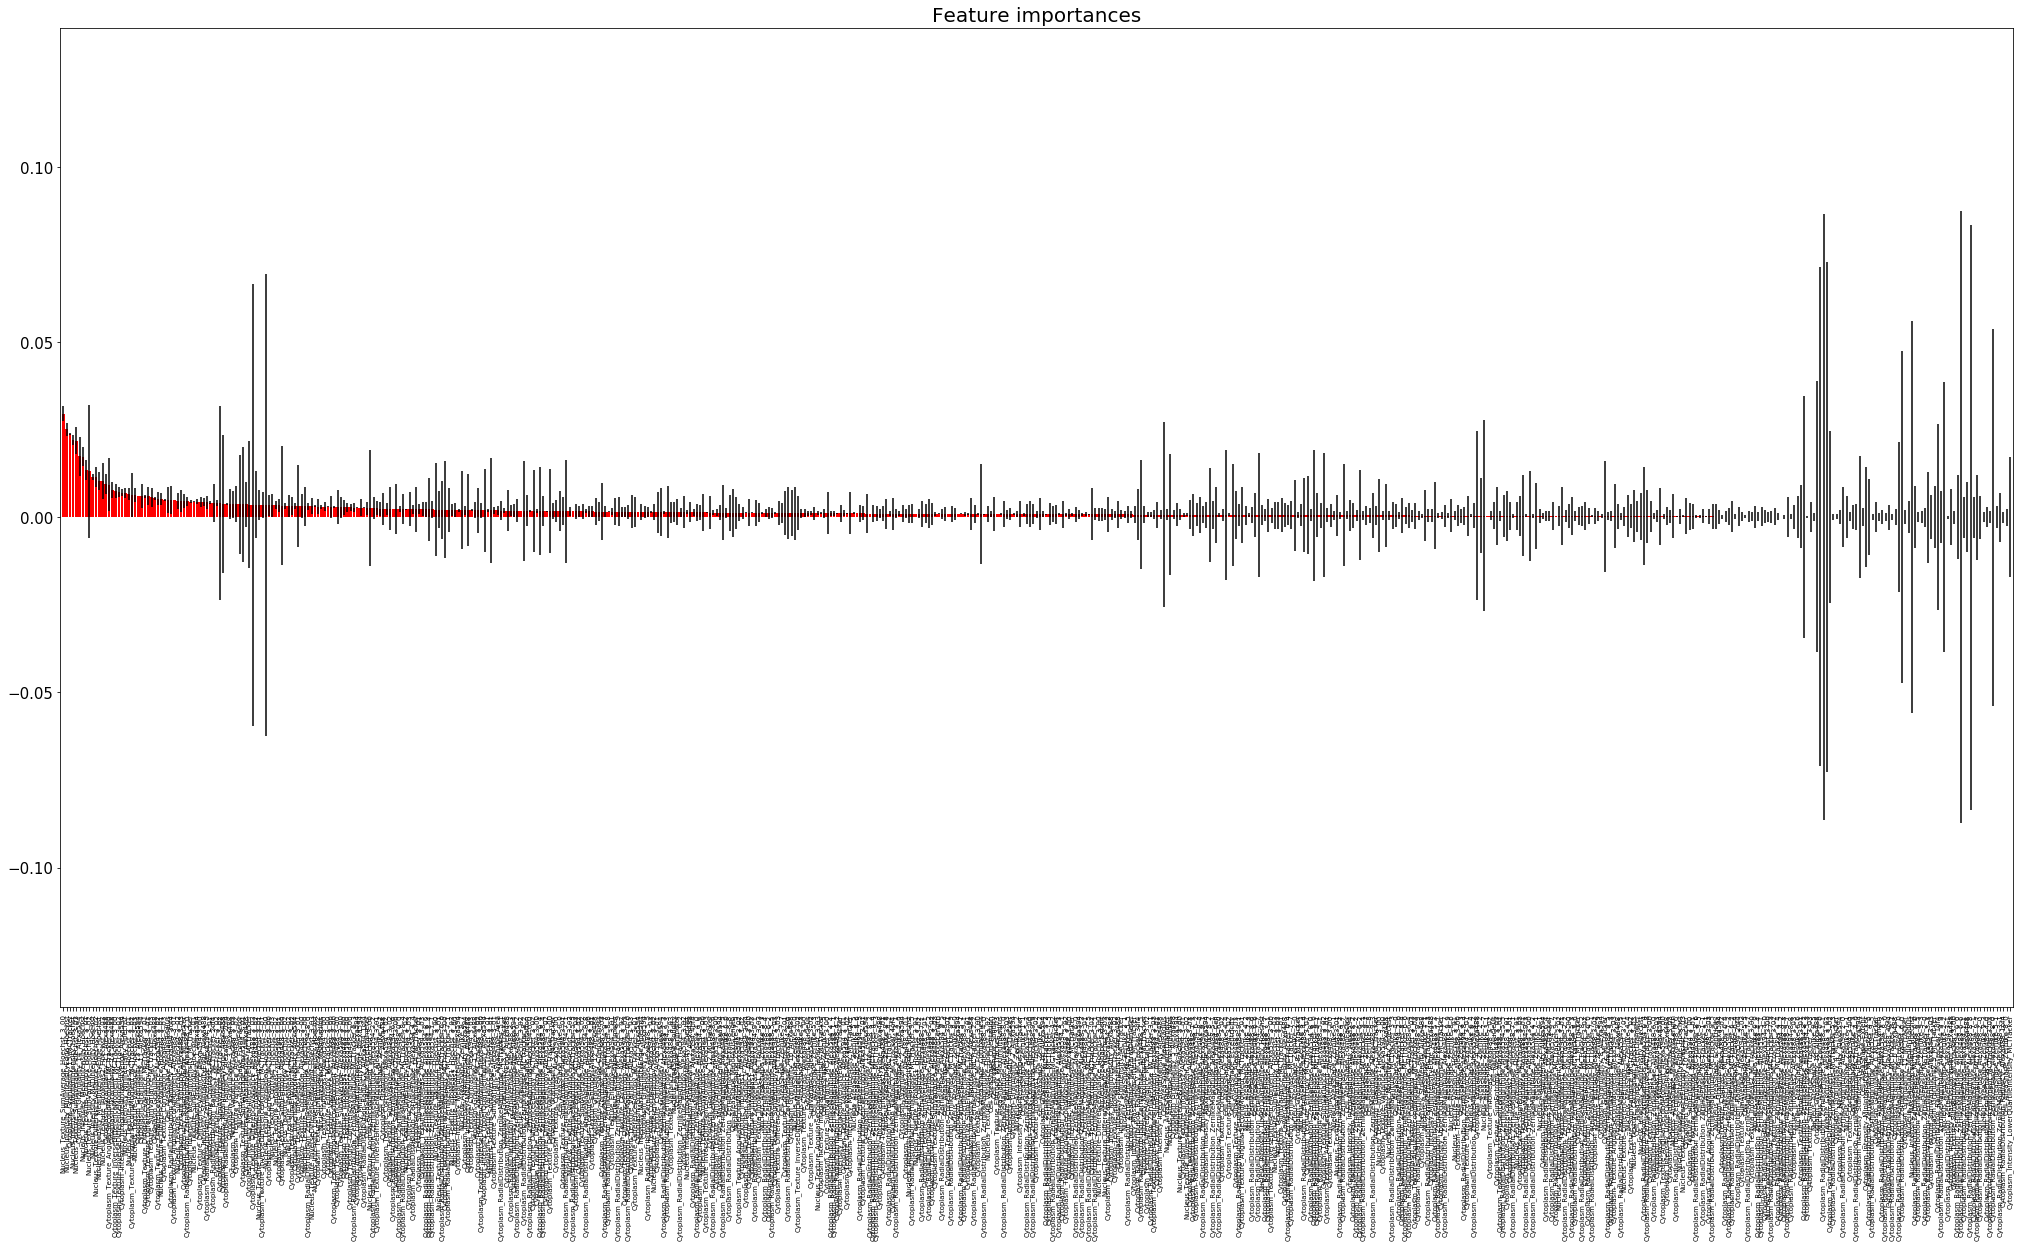

<Figure size 432x288 with 0 Axes>

In [54]:
important_features = pandas.Series(data=clf.feature_importances_, index=objects_train.columns)
important_features.sort_values(ascending=False,inplace=True)
std = numpy.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)       

# Plot the feature importances of the forest   
plt.figure(figsize=(35, 20))

plt.title("Feature importances",fontsize=20)
plt.bar(range(important_features.shape[0]), important_features, yerr = std, color="r", align="center")
feature_names = list(important_features.index)
plt.xticks(range(important_features.shape[0]), feature_names)
plt.xticks(rotation=90, fontsize=7)
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.3)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.2)
plt.xlim([-1, important_features.shape[0]])
matplotlib.rcParams.update({'font.size': 15})

plt_name = 'feature_ranking.png'
# plt.savefig(os.path.join(output_directory, plt_name))
plt.show()
plt.clf()

In [55]:
print('Lists of important features (Alphabetically sorted after ranking) :')
for i in data_train.columns.values:
    print(i)

Lists of important features (Alphabetically sorted after ranking) :
Cell_AreaShape_MaxFeretDiameter
Cell_AreaShape_MedianRadius
Cell_AreaShape_Zernike_0_0
Cell_AreaShape_Zernike_4_2
Cytoplasm_Granularity_11_Alexa488
Cytoplasm_Granularity_11_Alexa594
Cytoplasm_Granularity_13_Alexa488
Cytoplasm_Granularity_13_Alexa594
Cytoplasm_Granularity_13_MCTracker
Cytoplasm_Granularity_14_Alexa488
Cytoplasm_Granularity_14_Alexa594
Cytoplasm_Granularity_14_MCTracker
Cytoplasm_Granularity_15_Alexa488
Cytoplasm_Granularity_15_MCTracker
Cytoplasm_Granularity_1_Alexa594
Cytoplasm_Granularity_3_Alexa488
Cytoplasm_Granularity_3_MCTracker
Cytoplasm_Granularity_7_Alexa488
Cytoplasm_Intensity_IntegratedIntensityEdge_Alexa594
Cytoplasm_Intensity_LowerQuartileIntensity_Alexa594
Cytoplasm_Intensity_MADIntensity_Alexa488
Cytoplasm_Intensity_MaxIntensityEdge_Alexa488
Cytoplasm_Intensity_MaxIntensity_Alexa594
Cytoplasm_Intensity_MeanIntensityEdge_Alexa488
Cytoplasm_Intensity_MeanIntensityEdge_Alexa594
Cytoplasm_Int

In [56]:
list(set(merged_table_cleaned.ImageNumber))

[1, 2, 3, 4, 5, 6]

In [57]:
selected_table = merged_table_cleaned[merged_table_cleaned.ImageNumber==1].loc[:,data_train.columns.values]

In [59]:
selected_table.shape

(92, 161)

In [33]:
selected_table = selected_table.drop(selected_table.columns[selected_table.nunique() == 1], axis=1)

[Text(1, 0.5, 'Nucleus_Texture_InfoMeas1_Hoechst_3_02'),
 Text(1, 7.5, 'Nucleus_Texture_InverseDifferenceMoment_Hoechst_3_01'),
 Text(1, 14.5, 'Cytoplasm_Texture_DifferenceVariance_Alexa488_3_03'),
 Text(1, 21.5, 'Cytoplasm_Texture_AngularSecondMoment_MCTracker_3_02'),
 Text(1, 28.5, 'Cytoplasm_Texture_DifferenceVariance_Alexa594_3_00'),
 Text(1, 35.5, 'Nucleus_Texture_Contrast_Hoechst_3_01'),
 Text(1, 42.5, 'Nucleus_Intensity_LowerQuartileIntensity_Hoechst'),
 Text(1, 49.5, 'Nucleus_Texture_SumEntropy_Hoechst_3_01'),
 Text(1, 56.5, 'Cell_AreaShape_Zernike_4_2'),
 Text(1, 63.5, 'Cytoplasm_RadialDistribution_ZernikePhase_MCTracker_7_1'),
 Text(1, 70.5, 'Cytoplasm_Intensity_MinIntensity_Alexa594'),
 Text(1, 77.5, 'Cytoplasm_Intensity_MaxIntensity_Alexa594'),
 Text(1, 84.5, 'Cytoplasm_Intensity_UpperQuartileIntensity_Alexa594'),
 Text(1, 91.5, 'Cytoplasm_Granularity_14_Alexa594'),
 Text(1, 98.5, 'Cytoplasm_RadialDistribution_ZernikeMagnitude_Alexa594_6_4'),
 Text(1, 105.5, 'Cytoplasm_Text

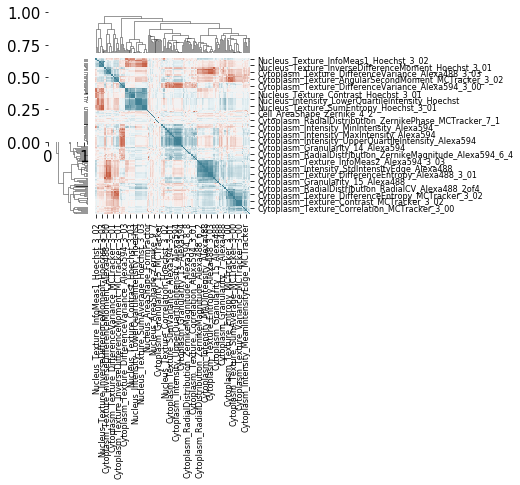

In [60]:
g = seaborn.clustermap(selected_table.corr(), cmap=seaborn.diverging_palette(20, 220, n=200), cbar=None)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 8)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 8)

# plt.savefig(os.path.join(output_dir, 'Baseline_fingerprint.png'), dpi = 300, tight_layout = True)

In [61]:
# Capture the features after hierachical clustering
orders_of_label = [selected_table.columns.values[i] for i in g.dendrogram_row.reordered_ind]

new_table = selected_table.corr()[orders_of_label]
new_table = new_table.loc[orders_of_label]


In [62]:
sorted(list(set(merged_table_cleaned.ImageNumber)))

[1, 2, 3, 4, 5, 6]

In [63]:
list_featuremeans_per_treatment = []

for t in sorted(list(set(merged_table_cleaned.ImageNumber))):

    temp = merged_table_cleaned[merged_table_cleaned['ImageNumber']==t].loc[:,orders_of_label]

    mean_per_feature = []
    for i,j in enumerate(orders_of_label):

        # Calculate mean values across all cells of individual feature
        mean_per_feature.append(numpy.mean(temp.loc[:,j]))

#     pandas.DataFrame(mean_per_feature).to_csv(os.path.join(output_dir,t+'.csv'))
    
    list_featuremeans_per_treatment.append(mean_per_feature)
    
    del(temp, mean_per_feature)
    gc.collect()

In [64]:
len(list_featuremeans_per_treatment)


6

In [65]:
len(list_featuremeans_per_treatment[0])

161

In [66]:
df = pandas.DataFrame.from_records(list_featuremeans_per_treatment, columns = orders_of_label)
df.shape

(6, 161)

In [67]:
df = df.T
df.columns = sorted(list(set(merged_table_cleaned.ImageNumber)))
df.shape
df.head(10)

,1,2,3,4,5,6
Nucleus_Texture_InfoMeas1_Hoechst_3_02,0.528674,-0.626006,-0.388152,0.172567,-0.191115,0.995032
Nucleus_Texture_InfoMeas1_Hoechst_3_03,0.565781,-0.648885,-0.439458,0.028581,-0.098376,1.141960
Nucleus_Intensity_MinIntensityEdge_Hoechst,0.111031,0.807794,0.416020,0.291866,-0.191151,-2.450385
Nucleus_Intensity_MinIntensity_Hoechst,0.113648,0.811141,0.403480,0.290194,-0.185230,-2.446893
Nucleus_Texture_AngularSecondMoment_Hoechst_3_00,-0.203546,-0.273583,-0.275521,-0.262811,-0.221164,1.966365
Nucleus_Texture_AngularSecondMoment_Hoechst_3_01,-0.198899,-0.263194,-0.264851,-0.255994,-0.216071,1.905694
Nucleus_Texture_InverseDifferenceMoment_Hoechst_3_03,-0.036011,-0.475101,-0.457068,-0.382431,-0.153632,2.452072
Nucleus_Texture_InverseDifferenceMoment_Hoechst_3_01,-0.006755,-0.462705,-0.462700,-0.406007,-0.178133,2.467464
Nucleus_Texture_DifferenceVariance_Hoechst_3_01,-0.227322,-0.329401,-0.331368,-0.322668,-0.238073,2.307767
Nucleus_Texture_DifferenceVariance_Hoechst_3_02,-0.226565,-0.342052,-0.344499,-0.335658,-0.233818,2.363770


[Text(1, 0.5, 'Cytoplasm_Granularity_11_Alexa594'),
 Text(1, 1.5, 'Nucleus_Texture_AngularSecondMoment_Hoechst_3_00'),
 Text(1, 2.5, 'Nucleus_Texture_AngularSecondMoment_Hoechst_3_01'),
 Text(1, 3.5, 'Nucleus_Texture_InverseDifferenceMoment_Hoechst_3_03'),
 Text(1, 4.5, 'Nucleus_Texture_InverseDifferenceMoment_Hoechst_3_01'),
 Text(1, 5.5, 'Nucleus_Texture_DifferenceVariance_Hoechst_3_01'),
 Text(1, 6.5, 'Nucleus_Texture_DifferenceVariance_Hoechst_3_02'),
 Text(1, 7.5, 'Cytoplasm_Granularity_14_Alexa594'),
 Text(1, 8.5, 'Cytoplasm_Granularity_14_Alexa488'),
 Text(1, 9.5, 'Cytoplasm_Granularity_1_Alexa594'),
 Text(1, 10.5, 'Nucleus_Intensity_LowerQuartileIntensity_Hoechst'),
 Text(1, 11.5, 'Nucleus_Intensity_MedianIntensity_Hoechst'),
 Text(1, 12.5, 'Nucleus_Intensity_MeanIntensity_Hoechst'),
 Text(1, 13.5, 'Nucleus_Texture_SumAverage_Hoechst_3_01'),
 Text(1, 14.5, 'Nucleus_Texture_SumAverage_Hoechst_3_03'),
 Text(1, 15.5, 'Nucleus_Texture_SumAverage_Hoechst_3_00'),
 Text(1, 16.5, 'Nucl

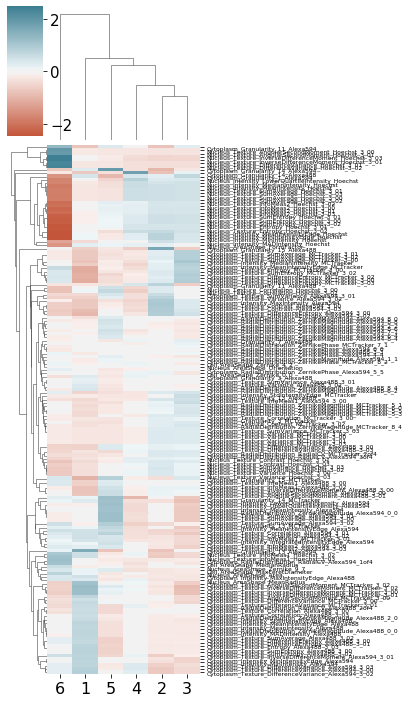

In [68]:
g = seaborn.clustermap(df, cmap=seaborn.diverging_palette(20, 220, n = 200),  xticklabels = 1, yticklabels = 1)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 6)
# plt.savefig(os.path.join(output_dir, 'which_is_similar_all_features.png'), dpi = 300, tight_layout = False)